In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
import subprocess
import yaml
import numpy as np
import xarray as xr
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import L1L2

from src.data_preparation import mdl_dataset

from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.modelling import mdl_history

from src.modelling import model_cnn
# from src.modelling import super_model_dl

from src.visualization import visualize_pca
from src.visualization import mdl_introspect
from src.visualization import mdl_ypred_PCA

from src.utils import reload_config
from src.utils import tardisml_utils

2023-04-03 10:57:14.399009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 10:57:16.837411: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 10:57:16.837464: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-03 10:57:40.012049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# add argument to pass config file
# narg = len(sys.argv)  # number of arguments passed
# if narg > 1:
#     file_config = sys.argv[1]
# else:
file_config = '../config/config_to_jobs/config_CNN_no_bias_0wk.yaml'


rootdir = tardisml_utils.get_rootdir()
# file_config = '../config/data_proc_full.yaml'
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

Config file found: ../config/config_to_jobs/config_CNN_no_bias_0wk.yaml
PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/config_to_jobs/config_CNN_no_bias_0wk.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821
Folder created

Subfolder created: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/
Subfolder created: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/figures/
Config file updated 'results_dir': ../config/config_to_jobs/config_CNN_no_bias_0wk.yaml
Config folders updated.
Config copied to: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821
Config file found: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/config_CNN_no_bias_0wk.yaml
Default config file is now the copied following one:
/nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/config_CNN_no_bias_0wk.yaml


In [3]:
# ---------------------------------------------------
#               Activate gpu if possible
# ---------------------------------------------------
import tensorflow as tf
ngpu = len(tf.config.list_physical_devices('GPU')) 
print("\nNum GPUs Available: ", ngpu)


# print(tf.__version__)
# print(tf.config.list_physical_devices())
#print(tf.config.list_logical_devices())

print(f'GPU device name:{tf.test.gpu_device_name()}')

# activation GPU
if ngpu > 0:
    tf.debugging.set_log_device_placement(True)
    print('Activation GPU')


Num GPUs Available:  0
GPU device name:


2023-04-03 10:58:21.839922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-03 10:58:21.840068: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 10:58:21.840153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-3.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2023-04-03 10:58:21.841692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# ---------------------------------------------------
#                 Defining parameters
# ---------------------------------------------------


# import pdb; pdb.set_trace()
H  = conf.load_history()['keras']['H']

if len(H) < 6:
    H = [-21,-14,-7,0,7,14,21,28, 35, 42, 49, 56, 63, 70, 77]

new_hist = mdl_history.History(conf)
new_hist.set_zeros()
new_hist.set_SIT_history('keras', H)

# var_to_keep = ['SITf t+0', 'sisnthick t+0', '2T t+0', '2T t+8', 'MSL t+0', 'TP t+0', 'TP t+8', 'siconc t+0']  # traditionnel
# var_to_keep = ['SITf t+0', 'sisnthick t+0', '2T t+0', 'MSL t+0', 'TP t+0', 'siconc t+0']  # cnn_230217-110450
var_to_keep = ['SITf t+0', 'sisnthick t+0', '2T t+0', 'MSL t+0', 'TP t+0', 'siconc t+0', 'SIA t+0']

print('SIA in !!')

SIA in !!


In [5]:
new_hist.params

{'bias': {'H': [1]},
 'covar': {'H': {'siconc': [0],
   'sisnthick': [0],
   'zos': [0],
   'vxsi': [0],
   'vysi': [0]}},
 'forcing': {'H': {'2T': [0],
   'MSL': [0],
   '10V': [0],
   '10U': [0],
   'TP': [0],
   'SSR': [0],
   'STR': [0]}},
 'keras': {'H': [-21, -14, -7, 0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77]},
 'noass': {'H': [0]}}

In [6]:
from src.data_preparation import mdl_dataset_prep

In [7]:
from importlib import reload

In [8]:
reload(mdl_dataset_prep)

<module 'src.data_preparation.mdl_dataset_prep' from '/cluster/home/leoede/tardis/tardis-ml/src/data_preparation/mdl_dataset_prep.py'>

In [9]:
reload(mdl_dataset)

<module 'src.data_preparation.mdl_dataset' from '/cluster/home/leoede/tardis/tardis-ml/src/data_preparation/mdl_dataset.py'>

In [10]:
# ---------------------------------------------------
#                 Loading data
# ---------------------------------------------------
# print('Loading data...')
#ds = mdl_dataset.Dataset(conf, setup='no_bias', history=new_hist, var_to_keep=var_to_keep)
ds = mdl_dataset.Dataset(conf, setup=conf.setup, history=new_hist, var_to_keep=var_to_keep)

regularizers = [L1L2(l1=0.01, l2=0)] # , L1L2(l1=0, l2=0.01), L1L2(l1=0.1, l2=0.1)]


Initialisation dataset...
Loading data...
Loading sia...
SIA off ! !!!!!!! just to be able to finish poster
	Retrieve siconc
	Retrieve sisnthick
	Retrieve zos
	Retrieve vxsi
	Retrieve vysi
Loading forcing values...
Loading pca...
Apply land/ocean mask...
Retrieve PCs and EOFs
Adding sia
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
nidx=0 negative history elements added
> /cluster/home/leoede/tardis/tardis-ml/src/data_preparation/mdl_dataset.py(566)data_to_dataset()
    564 
    565 
--> 566         Xsa, sahyperfeat, salabels = mdl_

In [11]:
conf.epochs = 50

In [12]:
# ---------------------------------------------------
#                 Building cnn
# ---------------------------------------------------

n_components = ds.config.n_comp['tp']

suffixe = ''  # useless ?
reg = regularizers[0]

    
m4 = model_cnn.ModelCNN(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], reg=reg, rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, fig_dir=ds.config.fig_dir)
m4.compile_models(npca=n_components)  # name

# dbug - should be good
# m4.print_summary()
# import pdb; pdb.set_trace()

m4.fit_multiple(ds.dataset, suffix=suffixe)
m4.print_histories()
m4.predict_multiple(ds.dataset)
m4.save_prediction()

# m4.save_model()
m4.save_model_weights()

ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw(m4, odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=False, ofile=ofile)



input change depending on model !!
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !
Fitting...
Epoch 1/50
458/458 [==============================] - 3s 3ms/step - loss: 1368.2025 - r_square: 0.0748 - root_mean_squared_error: 36.9892 - val_loss: 990.8329 - val_r_square: 0.1822 - val_root_mean_squared_error: 31.4775
Epoch 2/50
458/458 [==============================] - 1s 2ms/step - loss: 969.6242 - r_square: 0.3443 - root_mean_squared_error: 31.1388 - val_loss: 714.9551 - val_r_square: 0.4099 - val_root_mean_squared_error: 26.7386
Epoch 3/50
458/458 [==============================] - 1s 2ms/step - loss: 584.7377 - r_square: 0.6046 - root_mean_squared_error: 24.1814 - val_loss: 710.3837 - val_r_square: 0.4137 - val_root_mean_squared_error: 26.6530
Epoch 4/50
458/458 [==============================] - 1s 2ms/step - loss: 370.0755 - r_square: 0.7497 - root_mean_squared_error: 19.2373 - val_loss: 877.4719 - val_r_square: 0.2758 - val_root_mean_squared_

458/458 [==============================] - 1s 2ms/step - loss: 23.0404 - r_square: 0.9844 - root_mean_squared_error: 4.8000 - val_loss: 1021.9045 - val_r_square: 0.1566 - val_root_mean_squared_error: 31.9672
Epoch 38/50
458/458 [==============================] - 1s 2ms/step - loss: 21.4255 - r_square: 0.9855 - root_mean_squared_error: 4.6288 - val_loss: 978.2317 - val_r_square: 0.1926 - val_root_mean_squared_error: 31.2767
Epoch 39/50
458/458 [==============================] - 1s 2ms/step - loss: 20.1333 - r_square: 0.9864 - root_mean_squared_error: 4.4870 - val_loss: 1014.2814 - val_r_square: 0.1629 - val_root_mean_squared_error: 31.8478
Epoch 40/50
458/458 [==============================] - 1s 2ms/step - loss: 21.1757 - r_square: 0.9857 - root_mean_squared_error: 4.6017 - val_loss: 1065.7373 - val_r_square: 0.1204 - val_root_mean_squared_error: 32.6456
Epoch 41/50
458/458 [==============================] - 1s 2ms/step - loss: 19.8835 - r_square: 0.9866 - root_mean_squared_error: 4.45

458/458 [==============================] - 1s 2ms/step - loss: 25.4573 - r_square: 0.9745 - root_mean_squared_error: 5.0455 - val_loss: 874.2692 - val_r_square: -7.1319 - val_root_mean_squared_error: 29.5680
Epoch 25/50
458/458 [==============================] - 1s 2ms/step - loss: 24.3108 - r_square: 0.9757 - root_mean_squared_error: 4.9306 - val_loss: 888.9121 - val_r_square: -7.2680 - val_root_mean_squared_error: 29.8146
Epoch 26/50
458/458 [==============================] - 1s 2ms/step - loss: 24.5536 - r_square: 0.9755 - root_mean_squared_error: 4.9552 - val_loss: 875.5723 - val_r_square: -7.1440 - val_root_mean_squared_error: 29.5901
Epoch 27/50
458/458 [==============================] - 1s 2ms/step - loss: 22.8012 - r_square: 0.9772 - root_mean_squared_error: 4.7751 - val_loss: 860.0418 - val_r_square: -6.9995 - val_root_mean_squared_error: 29.3265
Epoch 28/50
458/458 [==============================] - 1s 2ms/step - loss: 22.1927 - r_square: 0.9778 - root_mean_squared_error: 4.7

458/458 [==============================] - 1s 2ms/step - loss: 32.4296 - r_square: 0.9666 - root_mean_squared_error: 5.6947 - val_loss: 777.9362 - val_r_square: -3.4929 - val_root_mean_squared_error: 27.8915
Epoch 12/50
458/458 [==============================] - 1s 2ms/step - loss: 29.7128 - r_square: 0.9694 - root_mean_squared_error: 5.4509 - val_loss: 886.4740 - val_r_square: -4.1198 - val_root_mean_squared_error: 29.7737
Epoch 13/50
458/458 [==============================] - 1s 2ms/step - loss: 26.5955 - r_square: 0.9726 - root_mean_squared_error: 5.1571 - val_loss: 855.7112 - val_r_square: -3.9421 - val_root_mean_squared_error: 29.2525
Epoch 14/50
458/458 [==============================] - 1s 2ms/step - loss: 24.9578 - r_square: 0.9743 - root_mean_squared_error: 4.9958 - val_loss: 745.3372 - val_r_square: -3.3046 - val_root_mean_squared_error: 27.3009
Epoch 15/50
458/458 [==============================] - 1s 2ms/step - loss: 23.1152 - r_square: 0.9762 - root_mean_squared_error: 4.8

458/458 [==============================] - 1s 2ms/step - loss: 10.0417 - r_square: 0.9897 - root_mean_squared_error: 3.1689 - val_loss: 896.7317 - val_r_square: -4.1790 - val_root_mean_squared_error: 29.9455
Epoch 49/50
458/458 [==============================] - 1s 2ms/step - loss: 10.2728 - r_square: 0.9894 - root_mean_squared_error: 3.2051 - val_loss: 809.2148 - val_r_square: -3.6736 - val_root_mean_squared_error: 28.4467
Epoch 50/50
458/458 [==============================] - 1s 2ms/step - loss: 10.5398 - r_square: 0.9892 - root_mean_squared_error: 3.2465 - val_loss: 882.5844 - val_r_square: -4.0973 - val_root_mean_squared_error: 29.7083
pc2 Training finished !
Epoch 1/50
458/458 [==============================] - 2s 3ms/step - loss: 619.2206 - r_square: 0.2281 - root_mean_squared_error: 24.8841 - val_loss: 302.4890 - val_r_square: -0.3152 - val_root_mean_squared_error: 17.3922
Epoch 2/50
458/458 [==============================] - 1s 2ms/step - loss: 243.7009 - r_square: 0.6962 - roo

458/458 [==============================] - 1s 2ms/step - loss: 10.6951 - r_square: 0.9867 - root_mean_squared_error: 3.2703 - val_loss: 452.8375 - val_r_square: -0.9688 - val_root_mean_squared_error: 21.2800
Epoch 36/50
458/458 [==============================] - 1s 2ms/step - loss: 10.6875 - r_square: 0.9867 - root_mean_squared_error: 3.2692 - val_loss: 497.8002 - val_r_square: -1.1643 - val_root_mean_squared_error: 22.3114
Epoch 37/50
458/458 [==============================] - 1s 2ms/step - loss: 10.4922 - r_square: 0.9869 - root_mean_squared_error: 3.2392 - val_loss: 570.4662 - val_r_square: -1.4803 - val_root_mean_squared_error: 23.8844
Epoch 38/50
458/458 [==============================] - 1s 2ms/step - loss: 10.2535 - r_square: 0.9872 - root_mean_squared_error: 3.2021 - val_loss: 451.2965 - val_r_square: -0.9621 - val_root_mean_squared_error: 21.2437
Epoch 39/50
458/458 [==============================] - 1s 2ms/step - loss: 10.8822 - r_square: 0.9864 - root_mean_squared_error: 3.2

458/458 [==============================] - 1s 2ms/step - loss: 20.7548 - r_square: 0.9551 - root_mean_squared_error: 4.5557 - val_loss: 1004.0281 - val_r_square: -0.2856 - val_root_mean_squared_error: 31.6864
Epoch 23/50
458/458 [==============================] - 1s 2ms/step - loss: 20.1362 - r_square: 0.9564 - root_mean_squared_error: 4.4873 - val_loss: 1063.1348 - val_r_square: -0.3613 - val_root_mean_squared_error: 32.6057
Epoch 24/50
458/458 [==============================] - 1s 2ms/step - loss: 19.4513 - r_square: 0.9579 - root_mean_squared_error: 4.4104 - val_loss: 1023.6854 - val_r_square: -0.3108 - val_root_mean_squared_error: 31.9951
Epoch 25/50
458/458 [==============================] - 1s 2ms/step - loss: 17.8903 - r_square: 0.9613 - root_mean_squared_error: 4.2297 - val_loss: 1047.9297 - val_r_square: -0.3419 - val_root_mean_squared_error: 32.3717
Epoch 26/50
458/458 [==============================] - 1s 2ms/step - loss: 17.6562 - r_square: 0.9618 - root_mean_squared_error:

458/458 [==============================] - 1s 2ms/step - loss: 35.4013 - r_square: 0.9226 - root_mean_squared_error: 5.9499 - val_loss: 235.4596 - val_r_square: -8.6459 - val_root_mean_squared_error: 15.3447
Epoch 10/50
458/458 [==============================] - 1s 2ms/step - loss: 28.7265 - r_square: 0.9372 - root_mean_squared_error: 5.3597 - val_loss: 238.7479 - val_r_square: -8.7806 - val_root_mean_squared_error: 15.4515
Epoch 11/50
458/458 [==============================] - 1s 2ms/step - loss: 24.5471 - r_square: 0.9463 - root_mean_squared_error: 4.9545 - val_loss: 254.6476 - val_r_square: -9.4320 - val_root_mean_squared_error: 15.9577
Epoch 12/50
458/458 [==============================] - 1s 2ms/step - loss: 20.7271 - r_square: 0.9547 - root_mean_squared_error: 4.5527 - val_loss: 289.5673 - val_r_square: -10.8625 - val_root_mean_squared_error: 17.0167
Epoch 13/50
458/458 [==============================] - 1s 2ms/step - loss: 18.3942 - r_square: 0.9598 - root_mean_squared_error: 4.

458/458 [==============================] - 1s 2ms/step - loss: 6.1311 - r_square: 0.9866 - root_mean_squared_error: 2.4761 - val_loss: 218.1621 - val_r_square: -7.9373 - val_root_mean_squared_error: 14.7703
Epoch 47/50
458/458 [==============================] - 1s 2ms/step - loss: 6.1897 - r_square: 0.9865 - root_mean_squared_error: 2.4879 - val_loss: 234.4562 - val_r_square: -8.6048 - val_root_mean_squared_error: 15.3120
Epoch 48/50
458/458 [==============================] - 1s 2ms/step - loss: 5.6901 - r_square: 0.9876 - root_mean_squared_error: 2.3854 - val_loss: 224.1234 - val_r_square: -8.1815 - val_root_mean_squared_error: 14.9708
Epoch 49/50
458/458 [==============================] - 1s 2ms/step - loss: 5.8652 - r_square: 0.9872 - root_mean_squared_error: 2.4218 - val_loss: 211.6571 - val_r_square: -7.6708 - val_root_mean_squared_error: 14.5484
Epoch 50/50
458/458 [==============================] - 1s 2ms/step - loss: 5.7860 - r_square: 0.9874 - root_mean_squared_error: 2.4054 -

458/458 [==============================] - 1s 2ms/step - loss: 5.0773 - r_square: 0.9876 - root_mean_squared_error: 2.2533 - val_loss: 188.0036 - val_r_square: 0.0142 - val_root_mean_squared_error: 13.7114
Epoch 34/50
458/458 [==============================] - 1s 2ms/step - loss: 5.1385 - r_square: 0.9874 - root_mean_squared_error: 2.2668 - val_loss: 178.2402 - val_r_square: 0.0654 - val_root_mean_squared_error: 13.3507
Epoch 35/50
458/458 [==============================] - 1s 2ms/step - loss: 5.3695 - r_square: 0.9869 - root_mean_squared_error: 2.3172 - val_loss: 137.1371 - val_r_square: 0.2809 - val_root_mean_squared_error: 11.7106
Epoch 36/50
458/458 [==============================] - 1s 2ms/step - loss: 5.0489 - r_square: 0.9876 - root_mean_squared_error: 2.2470 - val_loss: 149.6129 - val_r_square: 0.2155 - val_root_mean_squared_error: 12.2316
Epoch 37/50
458/458 [==============================] - 1s 2ms/step - loss: 5.0336 - r_square: 0.9877 - root_mean_squared_error: 2.2436 - val

458/458 [==============================] - 1s 2ms/step - loss: 15.1277 - r_square: 0.9422 - root_mean_squared_error: 3.8894 - val_loss: 233.5963 - val_r_square: -0.2182 - val_root_mean_squared_error: 15.2839
Epoch 21/50
458/458 [==============================] - 1s 2ms/step - loss: 14.0755 - r_square: 0.9462 - root_mean_squared_error: 3.7517 - val_loss: 240.9882 - val_r_square: -0.2567 - val_root_mean_squared_error: 15.5238
Epoch 22/50
458/458 [==============================] - 1s 2ms/step - loss: 12.7646 - r_square: 0.9512 - root_mean_squared_error: 3.5728 - val_loss: 227.3627 - val_r_square: -0.1857 - val_root_mean_squared_error: 15.0785
Epoch 23/50
458/458 [==============================] - 1s 2ms/step - loss: 12.6463 - r_square: 0.9517 - root_mean_squared_error: 3.5562 - val_loss: 239.0091 - val_r_square: -0.2464 - val_root_mean_squared_error: 15.4599
Epoch 24/50
458/458 [==============================] - 1s 2ms/step - loss: 12.5031 - r_square: 0.9522 - root_mean_squared_error: 3.5

Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC0
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC1
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC2
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC3
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC4
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC5
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC6
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/ml/model_weights_CNN_8N_PC7
Saved as: /nird/projects/nird/NS2993K/Leo/results/cnn_230403-105821/figures/CNN_ypred.png


# SHAP

In [13]:
import shap

In [47]:
# init the JS visualization code
shap.initjs()

In [14]:
# DEEP EXPLAINER - works with 3D dataset

explainer = shap.DeepExplainer(m4.models['pc0'], ds.dataset['Xtrain'])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [15]:
shap_values = explainer.shap_values(ds.dataset['X'])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [71]:
shap_values[0].shape

(2818, 15, 28)

In [51]:
# mean shap values over History
mean_shap = np.mean(shap_values[0][:],axis=(1))

In [16]:
ds.inputs

array(['SITf t+0 PC0', 'SITf t+0 PC1', 'SITf t+0 PC2', 'SITf t+0 PC3',
       'SITf t+0 PC4', 'SITf t+0 PC5', 'SITf t+0 PC6', 'SITf t+0 PC7',
       'sisnthick t+0 PC0', 'sisnthick t+0 PC1', 'sisnthick t+0 PC2',
       'sisnthick t+0 PC3', '2T t+0 PC0', '2T t+0 PC1', '2T t+0 PC2',
       '2T t+0 PC3', 'MSL t+0 PC0', 'MSL t+0 PC1', 'MSL t+0 PC2',
       'MSL t+0 PC3', 'TP t+0 PC0', 'TP t+0 PC1', 'TP t+0 PC2',
       'TP t+0 PC3', 'siconc t+0 PC0', 'siconc t+0 PC1', 'siconc t+0 PC2',
       'siconc t+0 PC3'], dtype='<U17')

In [18]:
explainer.expected_value.numpy()[0]

-3.856211

In [20]:
shap_values[0][0][0]

array([ 0.01480333,  0.25763814, -0.25698982, -0.2920356 , -0.00266988,
        0.12586481, -0.19969922, -0.0705013 ,  0.26627111, -0.10670151,
       -0.06598071,  0.00259723, -0.20991678, -0.02135384, -0.01557153,
       -0.00133257,  0.10379401,  0.00394387, -0.03477701, -0.05837945,
        0.02793374, -0.07010057,  0.0331018 ,  0.00894854, -0.00417529,
       -0.01797652, -0.04069523, -0.0780757 ])

In [24]:
shap.force_plot(explainer.expected_value.numpy()[0], shap_values[0][0][0], ds.inputs)

In [25]:
shap.force_plot(explainer.expected_value.numpy()[0], shap_values[0][1][0], ds.inputs)

In [31]:
mean_shap.shape

(1859, 28)

In [32]:
shap.force_plot(explainer.expected_value.numpy()[0], mean_shap, ds.inputs)

In [34]:
mean_shap.shape

(1859, 28)

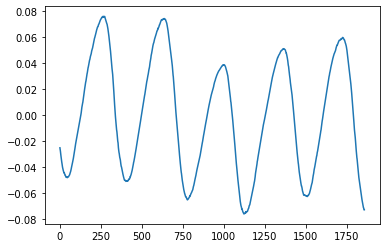

In [35]:
plt.plot(mean_shap[:,0])

In [ ]:
# we want to get most important shap value (=feature) at each timestep

In [39]:
mean_shap[0, :]

array([-0.02540908,  0.65022213, -0.19965391, -0.15460607,  0.06047689,
        0.02180649, -0.15460208, -0.00234064,  0.2426995 , -0.22135683,
       -0.07668454, -0.00445867, -0.23765896,  0.14659788, -0.01307339,
        0.01502511, -0.06625762, -0.01530639, -0.00628607,  0.03569778,
        0.01395966,  0.10166008,  0.00834619,  0.00845164, -0.03722392,
       -0.0044384 , -0.06364199, -0.12931206])

In [52]:
idx_max = np.argmax(abs(mean_shap[0, :]))

In [43]:
print(f'Most important SHAP feature for t={0}: {ds.inputs[idx_max]}')

Most important SHAP feature for t=0: SITf t+0 PC1


In [ ]:
# rank most important positive/negative values

In [45]:
np.sort(mean_shap[0, :])

array([-0.23765896, -0.22135683, -0.19965391, -0.15460607, -0.15460208,
       -0.12931206, -0.07668454, -0.06625762, -0.06364199, -0.03722392,
       -0.02540908, -0.01530639, -0.01307339, -0.00628607, -0.00445867,
       -0.0044384 , -0.00234064,  0.00834619,  0.00845164,  0.01395966,
        0.01502511,  0.02180649,  0.03569778,  0.06047689,  0.10166008,
        0.14659788,  0.2426995 ,  0.65022213])

In [53]:
n_neg = np.count_nonzero(mean_shap[0,:]<0)

In [61]:
np.argsort(mean_shap[0,:]) #- n_neg

array([12,  9,  2,  3,  6, 27, 10, 16, 26, 24,  0, 17, 14, 18, 11, 25,  7,
       22, 23, 20, 15,  5, 19,  4, 21, 13,  8,  1])

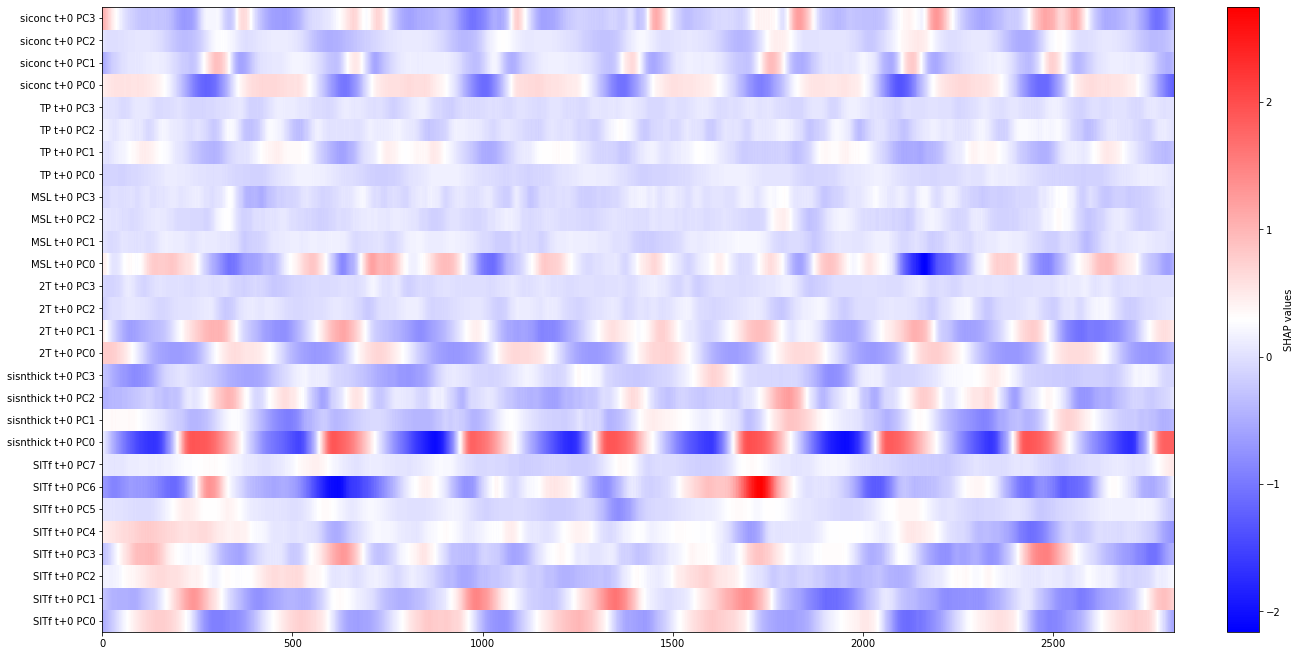

In [67]:
fig, ax = plt.subplots(figsize=(9*2, 9), constrained_layout=True)


plt.pcolor(mean_shap.T, cmap=plt.get_cmap('bwr')) # , interpolation='None') #, aspect='auto', 

ax.set_yticks(np.arange(len(ds.inputs))+0.5)
ax.set_yticklabels(ds.inputs)

plt.colorbar(label='SHAP values')

In [66]:
ds.inputs.shape

(28,)

In [18]:
def draw_shap_table(shap_val, ds, title='', **kwargs):
    fig, ax = plt.subplots(figsize=(9*2, 9), constrained_layout=True)


    plt.pcolor(shap_val.T, cmap=plt.get_cmap('bwr'), **kwargs) # , interpolation='None') #, aspect='auto', 

    ax.set_yticks(np.arange(len(ds.inputs))+0.5)
    ax.set_yticklabels(ds.inputs)

    plt.colorbar(label='SHAP values')
    
    plt.title(title)

In [75]:
shap_values[0].shape

(2818, 15, 28)

In [78]:
H

[-21, -14, -7, 0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77]

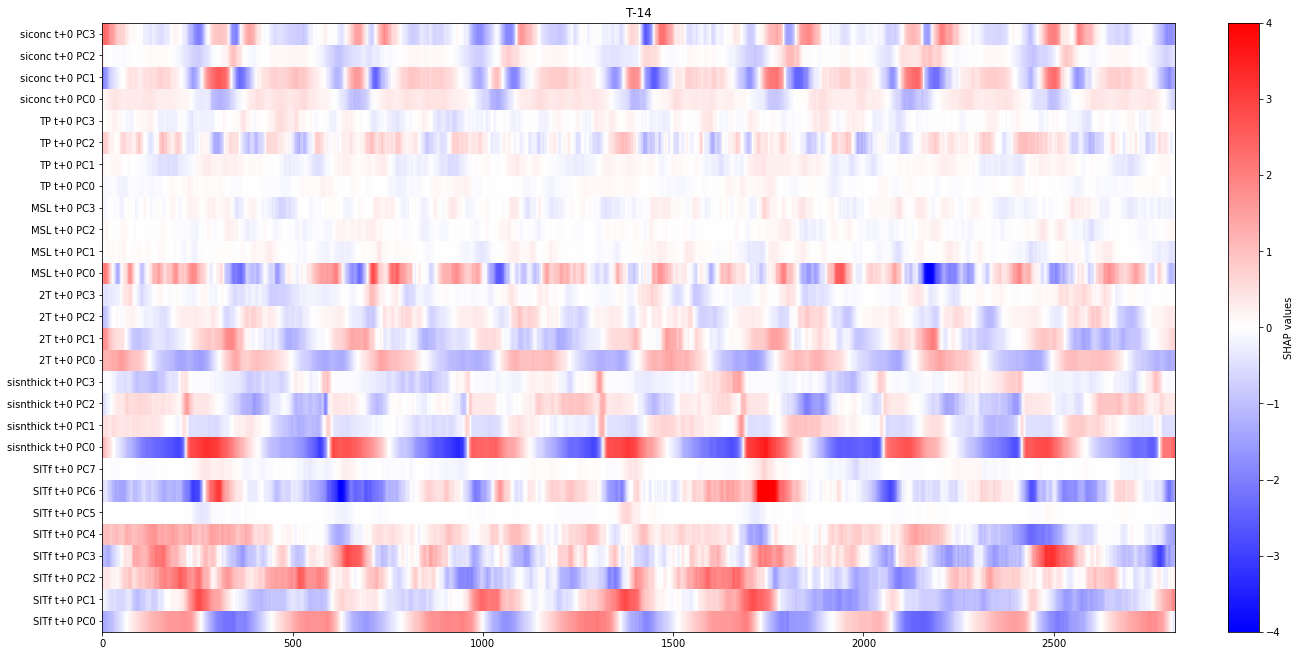

In [19]:
H_idx = 1
title = f'T{H[H_idx]}'
draw_shap_table(shap_values[0][:,H_idx], ds, title=title, vmin=-4, vmax=4)

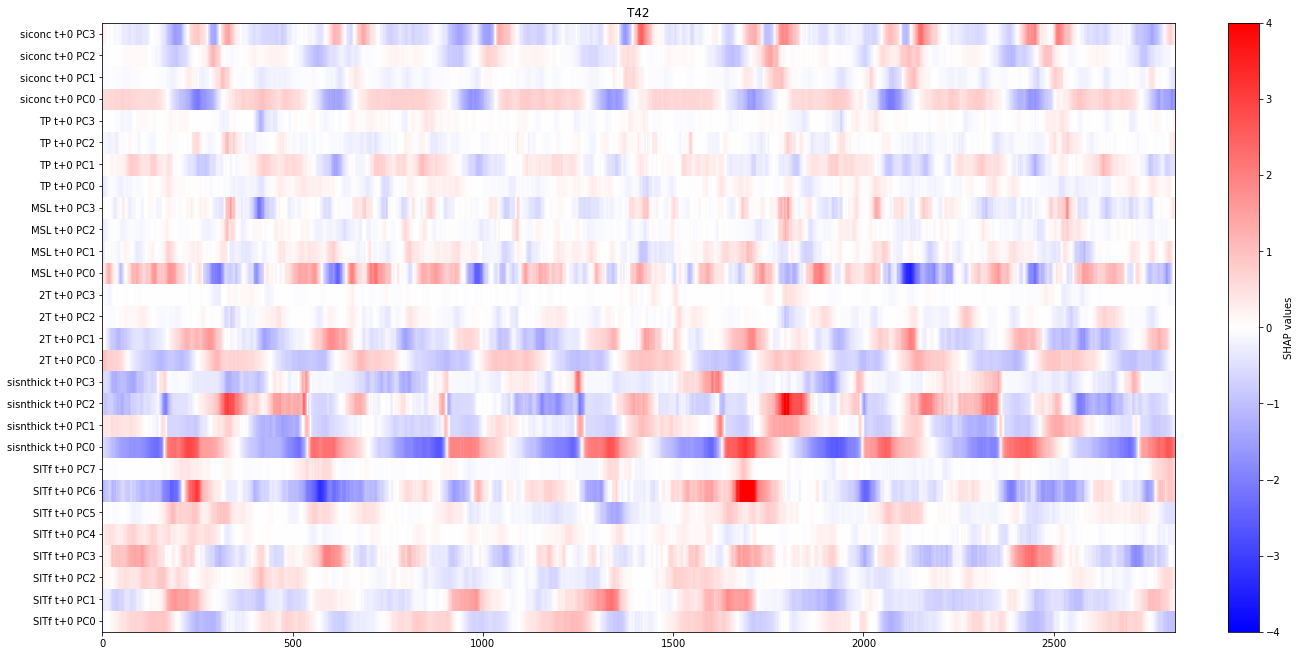

In [20]:
H_idx = 9
title = f'T{H[H_idx]}'
draw_shap_table(shap_values[0][:,H_idx], ds, title=title, vmin=-4, vmax=4)

In [24]:
shap_values[0].shape

(2818, 15, 28)

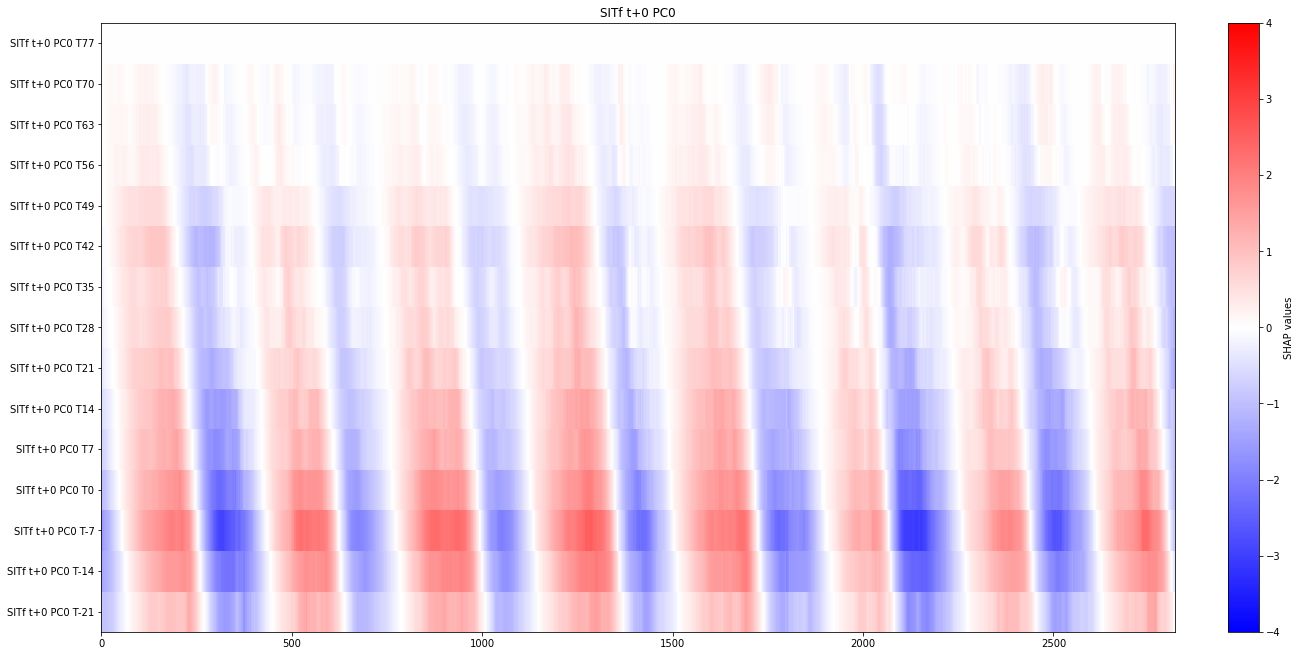

In [27]:
# one feature at different timestep
# H_idx = 9
feat_idx = 0
title = f'{ds.inputs[feat_idx]}'
draw_shap_1feat(shap_values[0][:,:,feat_idx], ds.inputs[feat_idx], H, title=title, vmin=-4, vmax=4)

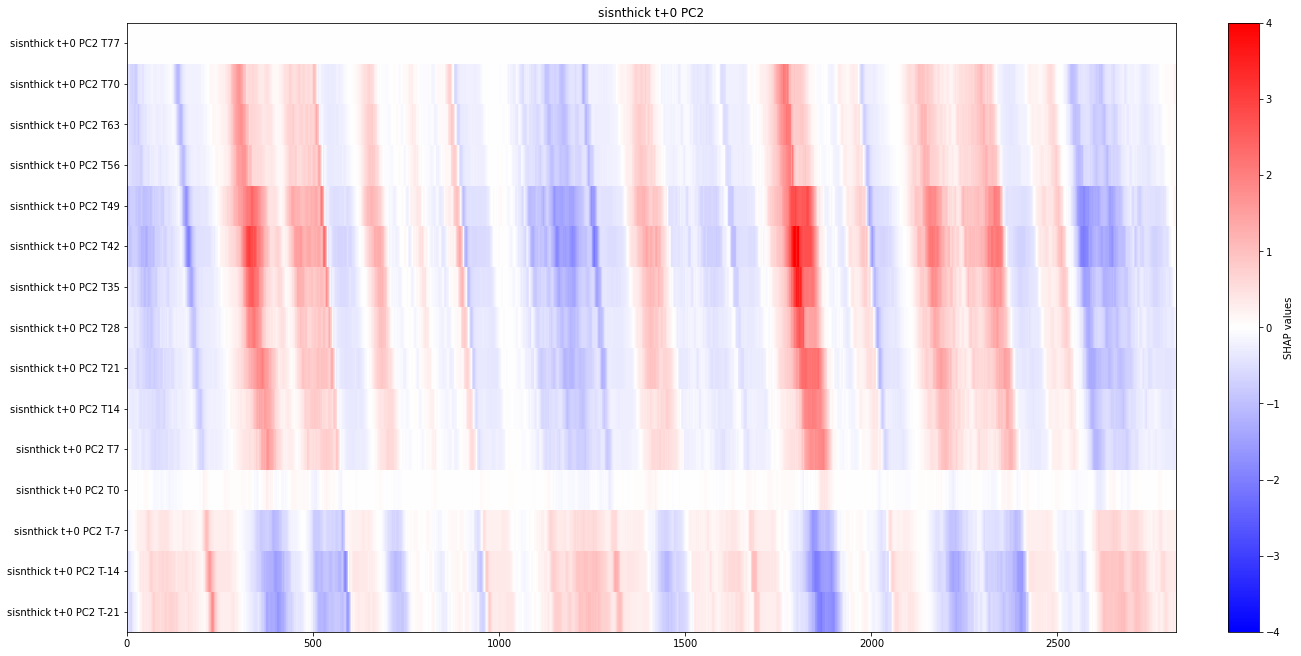

In [35]:
# one feature at different timestep
feat_idx = 10
title = f'{ds.inputs[feat_idx]}'
draw_shap_1feat(shap_values[0][:,:,feat_idx], ds.inputs[feat_idx], H, title=title, vmin=-4, vmax=4)

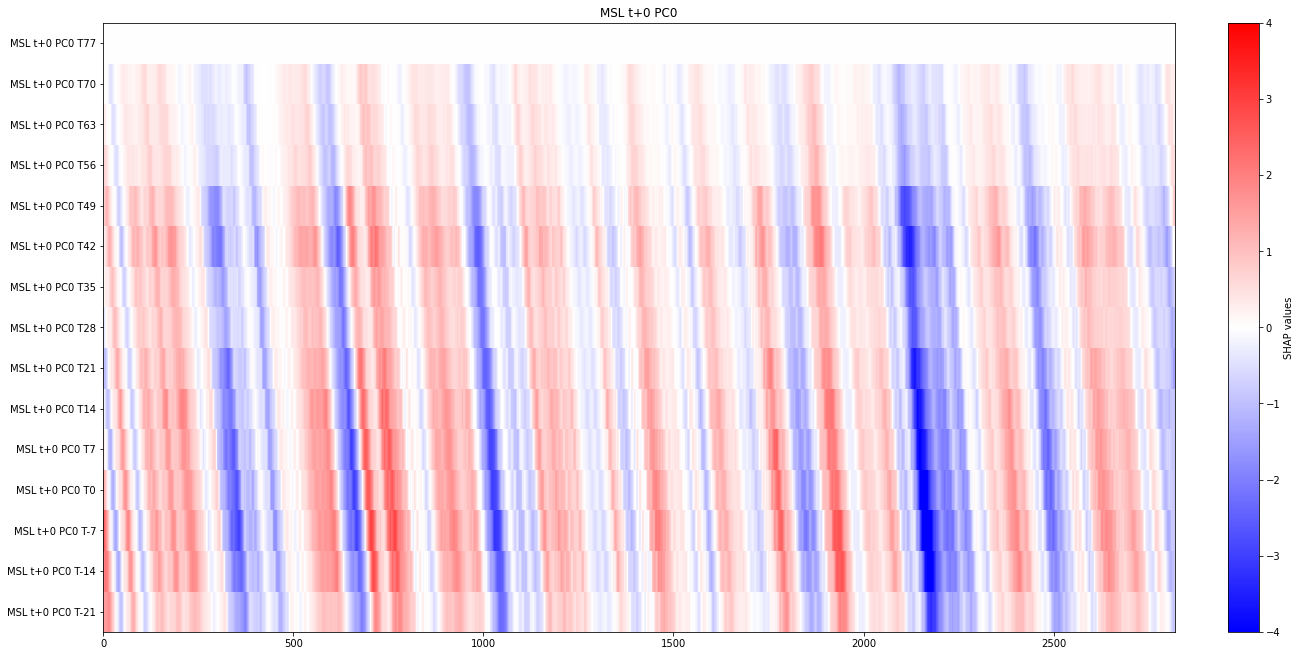

In [37]:
# one feature at different timestep
feat_idx = 16
title = f'{ds.inputs[feat_idx]}'
draw_shap_1feat(shap_values[0][:,:,feat_idx], ds.inputs[feat_idx], H, title=title, vmin=-4, vmax=4)

In [32]:
def draw_shap_1feat(shap_val, var_name, H, title='', **kwargs):
    nfeat = shap_val.shape[1]
    
    fig, ax = plt.subplots(figsize=(9*2, 9), constrained_layout=True)


    plt.pcolor(shap_val.T, cmap=plt.get_cmap('bwr'), **kwargs) # , interpolation='None') #, aspect='auto', 

    ax.set_yticks(np.arange(nfeat)+0.5)
    ax.set_yticklabels([f'{var_name} T{x}' for x in H])

    plt.colorbar(label='SHAP values')
    
    plt.title(title)